In [1]:
from astropy.io import ascii, fits
import astropy
import pylab as plt
%matplotlib inline
from astropy import wcs
from astropy.table import Table,Column,join,hstack,vstack
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.cosmology import WMAP9 as cosmo
import pymoc
import glob
from time import sleep
import os
from astropy.nddata.utils import Cutout2D
import herschelhelp.cutouts_server as ctts

import numpy as np
import xidplus
from xidplus import moc_routines
import pickle
import xidplus.catalogue as cat

import sys
from herschelhelp_internal.utils import inMoc,flux_to_mag
from xidplus.stan_fit import SPIRE

import aplpy
import seaborn as sns
#sns.set(color_codes=True)
import pandas as pd
#sns.set_style("white")
import xidplus.posterior_maps as postmaps
from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot, specz_merge
from herschelhelp import image_plotting
import pyvo as vo
import glob

import copy

In [2]:
def read_fits(filename):
    hdulist = fits.open(filename)
    data = hdulist[1].data
    hdulist.close()
    return(data)

In [3]:
def find_posteror_source(source_num,source_id):
    #finds the pkl file corresponding to the source you give.
    # Source_num: the row number of the source you want the pkl file for
    # Source_id: the sources id
    
    if type(source_num)==int:
        source_num = [source_num]
        source_id = [source_id]
    

    source_list = []
    for n,num in enumerate(source_num):
        file_num = int(num/10)
        #print(file_num)
        #print('data/fir_v2/xidplus_run_{}/lofar_xidplus_fir_{}_rerun.pkl.pkl'.format(file_num,file_num))
        name = file_list[file_num].replace('fits','pkl.pkl')
        #print(name)
        priors,posterior = xidplus.load(name)
        #print(source_id[n])
        if source_id[n] not in priors[0].ID:
            print('source number :{}: not in opened file. Something is wrong'.format(num))
        source_list.append([priors,posterior])
        
    return(source_list)

In [4]:
lofar_orig = Table.read('data/data_release/final_cross_match_catalogue-v0.5.fits')
mips_prior = Table.read('data/data_release/xidplus_prior_cat_MIPS.fits')
pacs_prior = Table.read('data/data_release/xidplus_prior_cat.fits')

In [5]:
lofar_orig[0]

Source_Name,RA,DEC,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,Maj,Min,PA,E_Maj,E_Min,E_PA,DC_Maj,DC_Min,DC_PA,Isl_rms,FLAG_WORKFLOW,Prefilter,NoID,lr_fin,optRA,optDec,LGZ_Size,LGZ_Width,LGZ_PA,Assoc,Assoc_Qual,Art_prob,Blend_prob,Hostbroken_prob,Imagemissing_prob,Zoom_prob,Created,Position_from,Renamed_from,FLAG_OVERLAP_RADIO,flag_clean_radio,ID,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,flag_clean,ID_OPTICAL,ID_SPITZER,FLAG_OVERLAP,u_flux_corr,u_fluxerr_corr,u_mag_corr,u_magerr_corr,g_flux_corr,g_fluxerr_corr,g_mag_corr,g_magerr_corr,r_flux_corr,r_fluxerr_corr,r_mag_corr,r_magerr_corr,i_flux_corr,i_fluxerr_corr,i_mag_corr,i_magerr_corr,z_flux_corr,z_fluxerr_corr,z_mag_corr,z_magerr_corr,y_flux_corr,y_fluxerr_corr,y_mag_corr,y_magerr_corr,g_hsc_flux_corr,g_hsc_fluxerr_corr,g_hsc_mag_corr,g_hsc_magerr_corr,r_hsc_flux_corr,r_hsc_fluxerr_corr,r_hsc_mag_corr,r_hsc_magerr_corr,i_hsc_flux_corr,i_hsc_fluxerr_corr,i_hsc_mag_corr,i_hsc_magerr_corr,z_hsc_flux_corr,z_hsc_fluxerr_corr,z_hsc_mag_corr,z_hsc_magerr_corr,y_hsc_flux_corr,y_hsc_fluxerr_corr,y_hsc_mag_corr,y_hsc_magerr_corr,nb921_hsc_flux_corr,nb921_hsc_fluxerr_corr,nb921_hsc_mag_corr,nb921_hsc_magerr_corr,J_flux_corr,J_fluxerr_corr,J_mag_corr,J_magerr_corr,K_flux_corr,K_fluxerr_corr,K_mag_corr,K_magerr_corr,ch1_swire_flux_corr,ch1_swire_fluxerr_corr,ch1_swire_mag_corr,ch1_swire_magerr_corr,ch2_swire_flux_corr,ch2_swire_fluxerr_corr,ch2_swire_mag_corr,ch2_swire_magerr_corr,ch3_swire_flux_corr,ch3_swire_fluxerr_corr,ch3_swire_mag_corr,ch3_swire_magerr_corr,ch4_swire_flux_corr,ch4_swire_fluxerr_corr,ch4_swire_mag_corr,ch4_swire_magerr_corr,ch1_servs_flux_corr,ch1_servs_fluxerr_corr,ch1_servs_mag_corr,ch1_servs_magerr_corr,ch2_servs_flux_corr,ch2_servs_fluxerr_corr,ch2_servs_mag_corr,ch2_servs_magerr_corr,Separation,help_id,RA_HELP,DEC_HELP,EBV,CLASS_STAR,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,Z_BEST,Z_BEST_SOURCE,Z_SPEC,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,AGN,optAGN,IRAGN,XrayAGN,hp_idx_11,hp_depth_cluster,tot_corr_g,tot_corr_err_g,tot_corr_r,tot_corr_err_r,tot_corr_z,tot_corr_err_z,zmodel,chi_best,Mass_median,Mass_l68,Mass_u68,SFR_median,SFR_l68,SFR_u68,Nfilts,u_rest,g_rest,r_rest,i_rest,z_rest,y_rest,J_rest,K_rest,ch1_servs_rest,ch2_servs_rest,ch1_swire_rest,ch2_swire_rest,ch3_swire_rest,ch4_swire_rest
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
bytes22,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,bytes22,bytes17,bytes22,int64,int64,int64,float32,float32,float64,float64,int64,int64,int32,int64,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,flo

## Check that the output from the other sources agrees with HELP

In [6]:
file_list = glob.glob('data/fir_MIPS_v10/*/lofar_xidplus*.pkl')
num_not = np.arange(428,860,1)

priors,posterior = xidplus.load(file_list[0])
MIPS_cat=cat.create_MIPS_cat(posterior,priors[0],0)
lofar_mips_table = Table.read(MIPS_cat,memmap=False)

for i,filename in enumerate(file_list[1:]):
    #print(filename)
    if i%50==0:
        print(i)
    
    priors,posterior = xidplus.load(filename)
    MIPS_cat=cat.create_MIPS_cat(posterior,priors[0],0)
    MIPS_cat = Table.read(MIPS_cat,memmap=False)
    lofar_mips_table = vstack([lofar_mips_table,MIPS_cat])
    

data_rerun_table = lofar_mips_table

0


In [7]:
lofar_mips_table[0]

help_id,RA,Dec,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24
,degrees,degrees,muJy,muJy,muJy,MJy / sr,MJy / sr,,,
str27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32
HELP_J160356.722+542722.094,240.98634189776928,54.45613727627435,71.56493,117.96191,23.08381,5.0810914,4.9017394e-06,0.9999967,2941.118,0.0


In [8]:
#read in the HELP catalogue
masterlist = Table.read('../../../../../HELP/dmu_products/dmu32/dmu32_ELAIS-N1/data/ELAIS-N1_20171020.fits')

In [9]:
joined = join(lofar_mips_table,masterlist,join_type='inner',keys='help_id')

In [16]:
joined[0]

help_id,RA,Dec,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,field,ra,dec,hp_idx,ebv,redshift,zspec,f_wfc_u,ferr_wfc_u,f_ap_wfc_u,ferr_ap_wfc_u,m_wfc_u,merr_wfc_u,m_ap_wfc_u,merr_ap_wfc_u,flag_wfc_u,f_megacam_u,ferr_megacam_u,f_ap_megacam_u,ferr_ap_megacam_u,m_megacam_u,merr_megacam_u,m_ap_megacam_u,merr_ap_megacam_u,flag_megacam_u,f_suprime_g,ferr_suprime_g,f_ap_suprime_g,ferr_ap_suprime_g,m_suprime_g,merr_suprime_g,m_ap_suprime_g,merr_ap_suprime_g,flag_suprime_g,f_megacam_g,ferr_megacam_g,f_ap_megacam_g,ferr_ap_megacam_g,m_megacam_g,merr_megacam_g,m_ap_megacam_g,merr_ap_megacam_g,flag_megacam_g,f_gpc1_g,ferr_gpc1_g,f_ap_gpc1_g,ferr_ap_gpc1_g,m_gpc1_g,merr_gpc1_g,m_ap_gpc1_g,merr_ap_gpc1_g,flag_gpc1_g,f_wfc_g,ferr_wfc_g,f_ap_wfc_g,ferr_ap_wfc_g,m_wfc_g,merr_wfc_g,m_ap_wfc_g,merr_ap_wfc_g,flag_wfc_g,f_suprime_r,ferr_suprime_r,f_ap_suprime_r,ferr_ap_suprime_r,m_suprime_r,merr_suprime_r,m_ap_suprime_r,merr_ap_suprime_r,flag_suprime_r,f_gpc1_r,ferr_gpc1_r,f_ap_gpc1_r,ferr_ap_gpc1_r,m_gpc1_r,merr_gpc1_r,m_ap_gpc1_r,merr_ap_gpc1_r,flag_gpc1_r,f_wfc_r,ferr_wfc_r,f_ap_wfc_r,ferr_ap_wfc_r,m_wfc_r,merr_wfc_r,m_ap_wfc_r,merr_ap_wfc_r,flag_wfc_r,f_megacam_r,ferr_megacam_r,f_ap_megacam_r,ferr_ap_megacam_r,m_megacam_r,merr_megacam_r,m_ap_megacam_r,merr_ap_megacam_r,flag_megacam_r,f_gpc1_i,ferr_gpc1_i,f_ap_gpc1_i,ferr_ap_gpc1_i,m_gpc1_i,merr_gpc1_i,m_ap_gpc1_i,merr_ap_gpc1_i,flag_gpc1_i,f_suprime_i,ferr_suprime_i,f_ap_suprime_i,ferr_ap_suprime_i,m_suprime_i,merr_suprime_i,m_ap_suprime_i,merr_ap_suprime_i,flag_suprime_i,f_wfc_i,ferr_wfc_i,f_ap_wfc_i,ferr_ap_wfc_i,m_wfc_i,merr_wfc_i,m_ap_wfc_i,merr_ap_wfc_i,flag_wfc_i,f_gpc1_z,ferr_gpc1_z,f_ap_gpc1_z,ferr_ap_gpc1_z,m_gpc1_z,merr_gpc1_z,m_ap_gpc1_z,merr_ap_gpc1_z,flag_gpc1_z,f_wfc_z,ferr_wfc_z,f_ap_wfc_z,ferr_ap_wfc_z,m_wfc_z,merr_wfc_z,m_ap_wfc_z,merr_ap_wfc_z,flag_wfc_z,f_megacam_z,ferr_megacam_z,f_ap_megacam_z,ferr_ap_megacam_z,m_megacam_z,merr_megacam_z,m_ap_megacam_z,merr_ap_megacam_z,flag_megacam_z,f_suprime_z,ferr_suprime_z,f_ap_suprime_z,ferr_ap_suprime_z,m_suprime_z,merr_suprime_z,m_ap_suprime_z,merr_ap_suprime_z,flag_suprime_z,f_suprime_n921,ferr_suprime_n921,f_ap_suprime_n921,ferr_ap_suprime_n921,m_suprime_n921,merr_suprime_n921,m_ap_suprime_n921,merr_ap_suprime_n921,flag_suprime_n921,f_gpc1_y,ferr_gpc1_y,f_ap_gpc1_y,ferr_ap_gpc1_y,m_gpc1_y,merr_gpc1_y,m_ap_gpc1_y,merr_ap_gpc1_y,flag_gpc1_y,f_suprime_y,ferr_suprime_y,f_ap_suprime_y,ferr_ap_suprime_y,m_suprime_y,merr_suprime_y,m_ap_suprime_y,merr_ap_suprime_y,flag_suprime_y,f_ukidss_j,ferr_ukidss_j,f_ap_ukidss_j,ferr_ap_ukidss_j,m_ukidss_j,merr_ukidss_j,m_ap_ukidss_j,merr_ap_ukidss_j,flag_ukidss_j,f_ukidss_k,ferr_ukidss_k,f_ap_ukidss_k,ferr_ap_ukidss_k,m_ukidss_k,merr_ukidss_k,m_ap_ukidss_k,merr_ap_ukidss_k,flag_ukidss_k,f_irac_i1,ferr_irac_i1,f_ap_irac_i1,ferr_ap_irac_i1,m_irac_i1,merr_irac_i1,m_ap_irac_i1,merr_ap_irac_i1,flag_irac_i1,f_irac_i2,ferr_irac_i2,f_ap_irac_i2,ferr_ap_irac_i2,m_irac_i2,merr_irac_i2,m_ap_irac_i2,merr_ap_irac_i2,flag_irac_i2,f_irac_i3,ferr_irac_i3,f_ap_irac_i3,ferr_ap_irac_i3,m_irac_i3,merr_irac_i3,m_ap_irac_i3,merr_ap_irac_i3,flag_irac_i3,f_irac_i4,ferr_irac_i4,f_ap_irac_i4,ferr_ap_irac_i4,m_irac_i4,merr_irac_i4,m_ap_irac_i4,merr_ap_irac_i4,flag_irac_i4,f_mips_24,ferr_mips_24,flag_mips_24,f_pacs_green,ferr_pacs_green,flag_pacs_green,f_pacs_red,ferr_pacs_red,flag_pacs_red,f_spire_250,ferr_spire_250,flag_spire_250,f_spire_350,ferr_spire_350,flag_spire_350,f_spire_500,ferr_spire_500,flag_spire_500,cigale_mstar,cigale_mstar_err,cigale_sfr,cigale_sfr_err,cigale_dustlumin,cigale_dustlumin_err,cigale_dustlumin_ironly,cigale_dustlumin_ironly_err,flag_cigale,flag_cigale_opt,flag_cigale_ir,flag_cigale_ironly,stellarity,stellarity_origin,flag_cleaned,flag_merged,flag_gaia,flag_optnir_obs,flag_optnir_det,zspec_qual,zspec_association_flag
,degrees,degrees,muJy,muJy,muJy,MJy / sr,MJy / sr,,,,,deg,deg,,,,,,,,,,,,,,,,,,mag,mag,,,,,,,,,,,,,,,,,mag,mag,,,,,,,,,,,,

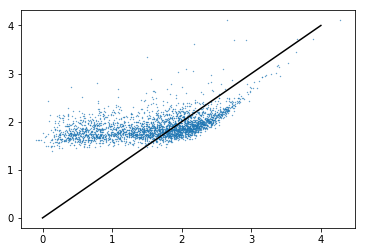

In [35]:
x = np.log10(joined['f_mips_24'])
xerr = np.log10(joined['ferr_mips_24'])
y = np.log10(joined['F_MIPS_24'])
yerr_u = np.log10(joined['FErr_MIPS_24_u']-joined['F_MIPS_24'])
yerr_l = np.log10(joined['F_MIPS_24']-joined['FErr_MIPS_24_l'])

#plt.errorbar(x[::10],y[::10],xerr=xerr[::10],yerr=[yerr_u[::10],yerr_l[::10]],linestyle='')
plt.scatter(x,y,s=0.1)
plt.plot([0,4],[0,4],c='black')
plt.show()

In [40]:
plot_params = {'marker':['o','+','s','v','X','d'],
              'col':['green','cyan','orange','red'],
              'size':100,
              'box_length':1/60,
              'use_redshift':[False,False,False,False]}

contours are at [-7.03488459e-05 -2.84357747e-05  1.34772965e-05  5.53903676e-05
  9.73034388e-05  1.39216510e-04  1.81129581e-04]
plotting 4 sources
plotting 3 sources
plotting 1 sources
plotting 1 sources


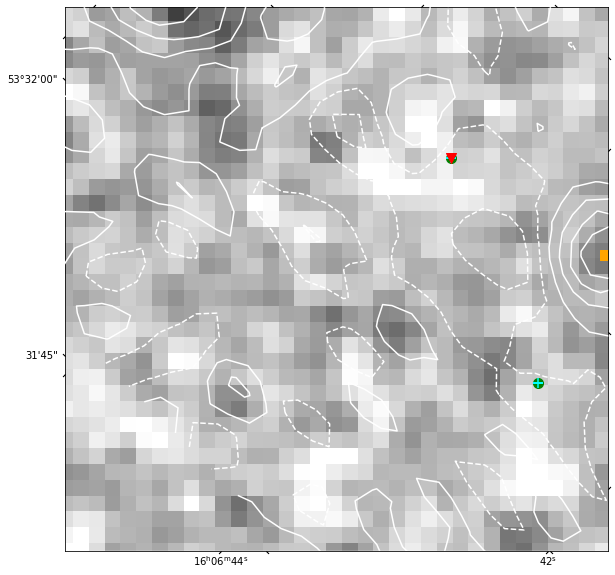

In [43]:
mask = np.log10(joined['f_mips_24'])<0.1
ra = joined[mask]['ra'][1]
dec = joined[mask]['dec'][1]

image_plotting.plot_figure(im24,[mips_prior,lofar_mips_table,lofar_orig,joined[mask]],w_24,ra,dec,plot_params,contour_data=[radim_data,radim_wcs])

## Processing MIPS output

In [ ]:
file_list = glob.glob('data/fir_MIPS_v10/*/lofar_xidplus*.fits')
num_not = np.arange(428,860,1)

lofar_mips_table = Table.read(file_list[0])
for i,filename in enumerate(file_list[1:]):
    #print(filename)
    if i%50==0:
        print(i)
    
    run_num = 0
    try:
        run_num = int(filename[24:27])
    except:
        run_num = 0
    #print(run_num)
    if run_num>428:
        continue
    
    #print(filename)
    new_table = Table.read(filename,memmap=False)
    if len(new_table)!=100:
        print(filename)
        print('length of table is: {}'.format(len(new_table)))
    lofar_mips_table = vstack([lofar_mips_table,new_table])
data_rerun_table = lofar_mips_table

In [ ]:
lofar_mips_table[0]

In [ ]:
skew=(lofar_mips_table['FErr_MIPS_24_u']-lofar_mips_table['F_MIPS_24'])/(lofar_mips_table['F_MIPS_24']-lofar_mips_table['FErr_MIPS_24_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(lofar_mips_table['F_MIPS_24']),y=skew, kind='hex')

skew=(lofar_orig['FErr_MIPS_24_u']-lofar_orig['F_MIPS_24'])/(lofar_orig['F_MIPS_24']-lofar_orig['FErr_MIPS_24_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(lofar_orig['F_MIPS_24']),y=skew, kind='hex')

In [ ]:
lofar_mips_table.add_column(Column(np.zeros(len(data_rerun_table), dtype=bool),name='flag_MIPS_24'))



In [ ]:
ind_SERVS_250=(lofar_mips_table['Pval_res_24']>0.5) | (lofar_mips_table['F_MIPS_24'] <20)
print(ind_SERVS_250.sum(),len(lofar_mips_table))

lofar_mips_table['flag_MIPS_24'][ind_SERVS_250]=True

In [ ]:
rerun_col = Column(np.ones(len(lofar_mips_table)),name='XID+_rerun_mips',dtype='bool')
lofar_mips_table.add_column(rerun_col)

In [ ]:
lofar_mips_table[0]

### Plot mips sources

In [36]:
#read in mips image and create wcs
imfolder='../../../../../HELP/dmu_products/dmu17/dmu17_HELP_Legacy_maps/ELAIS-N1/data/'

pswfits=imfolder+'wp4_elais-n1_mips24_map_v1.0.fits.gz'#SPIRE 250 map

MIPS_Map = fits.open(pswfits)

#-----250-------------
hdulist = fits.open(pswfits)
im24phdu=hdulist[0].header
im24hdu=hdulist[1].header

im24=hdulist[1].data*1.0E3 #convert to mJy
nim24=hdulist[2].data*1.0E3 #convert to mJy
w_24 = wcs.WCS(hdulist[1].header)
hdulist.close()

In [37]:
fname = 'data/data_release/radio_image.fits'
hdulist = fits.open(fname)
radim_header = hdulist[0].header
radim_wcs = wcs.WCS(radim_header).celestial
radim_data = hdulist[0].data[0][0]
hdulist.close()

In [38]:
plot_params = {'marker':['o','+','s','v','X','d'],
              'col':['green','cyan','orange'],
              'size':100,
              'box_length':1/60,
              'use_redshift':[False,False,False,False]}

In [ ]:
lofar_mips_table[mask][3]

In [ ]:
mask = lofar_mips_table['F_MIPS_24']>10**2.5
ra = lofar_mips_table['RA'][mask][3]
dec = lofar_mips_table['Dec'][mask][3]

ra = 244.01967769676352
dec = 55.61836714885293
image_plotting.plot_figure(im24,[mips_prior,lofar_mips_table,lofar_orig],w_24,ra,dec,plot_params,contour_data=[radim_data,radim_wcs])

## Check PACS results against HELP results

In [22]:
file_list = glob.glob('data/fir_PACS_v10/*/lofar_xidplus*.pkl')
num_not = np.arange(428,860,1)

priors,posterior = xidplus.load(file_list[0])
PACS_cat=cat.create_PACS_cat(posterior,priors[0],priors[1])
lofar_pacs_table = Table.read(PACS_cat,memmap=False)

for i,filename in enumerate(file_list[1:]):
    #print(filename)
    if i%50==0:
        print(i)
    
    priors,posterior = xidplus.load(filename)
    PACS_cat=cat.create_PACS_cat(posterior,priors[0],priors[1])
    PACS_cat = Table.read(PACS_cat,memmap=False)
    lofar_pacs_table = vstack([lofar_pacs_table,PACS_cat])
    

data_rerun_table = lofar_pacs_table

0
50


In [23]:
joined_pacs = join(lofar_pacs_table,masterlist,join_type='inner',keys='help_id')

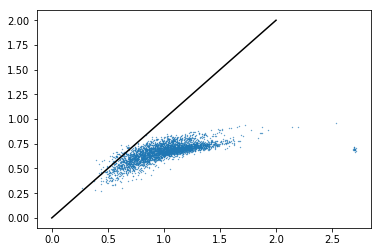

In [29]:
x = np.log10(joined_pacs['f_pacs_green'])-3
xerr = np.log10(joined_pacs['ferr_pacs_green'])-3
y = np.log10(joined_pacs['F_PACS_100'])
yerr_u = np.log10(joined_pacs['FErr_PACS_100_u'])
yerr_l = np.log10(joined_pacs['FErr_PACS_100_l'])

#plt.errorbar(x,y,xerr=xerr,yerr=[yerr_u,yerr_l])
plt.scatter(x,y,s=0.1)
plt.plot([0,2],[0,2],c='black')
plt.show()

## Processing PACS output

In [ ]:
file_list = glob.glob('data/fir_PACS_v10/*/lofar_xidplus_fir*.fits')
#num_not = np.arange(428,860,1)

lofar_pacs_table = Table.read(file_list[0])
for i,filename in enumerate(file_list[1:]):
    #print(filename)
    if i%50==0:
        print(i)
    
    #print(filename)
    new_table = Table.read(filename,memmap=False)
    if len(new_table)!=20:
        print(filename)
        print('length of table is: {}'.format(len(new_table)))
    lofar_pacs_table = vstack([lofar_pacs_table,new_table])
data_rerun_table = lofar_pacs_table

In [ ]:
lofar_pacs_table[0]

In [ ]:
skew=(lofar_pacs_table['FErr_PACS_100_u']-lofar_pacs_table['F_PACS_100'])/(lofar_pacs_table['F_PACS_100']-lofar_pacs_table['FErr_PACS_100_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(lofar_pacs_table['F_PACS_100']),y=skew, kind='hex')

skew=(lofar_orig['FErr_PACS_100_u']-lofar_orig['F_PACS_100'])/(lofar_orig['F_PACS_100']-lofar_orig['FErr_PACS_100_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(lofar_orig['F_PACS_100']),y=skew, kind='hex')

skew=(lofar_pacs_table['FErr_PACS_160_u']-lofar_pacs_table['F_PACS_160'])/(lofar_pacs_table['F_PACS_160']-lofar_pacs_table['FErr_PACS_160_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(lofar_pacs_table['F_PACS_160']),y=skew, kind='hex')

skew=(lofar_orig['FErr_PACS_160_u']-lofar_orig['F_PACS_160'])/(lofar_orig['F_PACS_160']-lofar_orig['FErr_PACS_160_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(lofar_orig['F_PACS_160']),y=skew, kind='hex')

In [ ]:
lofar_pacs_table.add_column(Column(np.zeros(len(lofar_pacs_table), dtype=bool),name='flag_PACS_100'))
lofar_pacs_table.add_column(Column(np.zeros(len(lofar_pacs_table), dtype=bool),name='flag_PACS_160'))

In [ ]:
ind_SERVS_100=(lofar_pacs_table['Pval_res_100']>0.5) | (lofar_pacs_table['F_PACS_100'] < 12.5)
ind_SERVS_160=(lofar_pacs_table['Pval_res_160']>0.5) | (lofar_pacs_table['F_PACS_160'] < 17.5)
print(ind_SERVS_100.sum(),ind_SERVS_160.sum(),len(lofar_pacs_table))

lofar_pacs_table['flag_PACS_100'][ind_SERVS_100]=True
lofar_pacs_table['flag_PACS_160'][ind_SERVS_160]=True

In [ ]:
rerun_col = Column(np.ones(len(lofar_pacs_table)),name='XID+_rerun_pacs',dtype='bool')
lofar_pacs_table.add_column(rerun_col)

In [ ]:
lofar_pacs_table[0]

In [ ]:
imfolder='../../../../../HELP/dmu_products/dmu18/dmu18_ELAIS-N1/data/'

im100fits=imfolder + 'ELAIS-N1-100um-img_wgls.fits'#PACS 100 map
nim100fits=imfolder + 'ELAIS-N1-100um-img_noise.fits'#PACS 100 noise map

hdulist = fits.open(im100fits)
im100phdu=hdulist[0].header
im100hdu=hdulist[0].header
im100=hdulist[0].data
w_100 = wcs.WCS(hdulist[0].header)
pixsize100=3600.0*np.abs(hdulist[0].header['CDELT1']) #pixel size (in arcseconds)
hdulist.close()

hdulist = fits.open(nim100fits)
nim100=hdulist[0].data
hdulist.close()

In [ ]:
plot_params = {'marker':['o','+','s','v','X','d'],
              'col':['green','cyan','orange'],
              'size':100,
              'box_length':1/60,
              'use_redshift':[False,False,False]}

In [ ]:
#mask = lofar_pacs_table['F_PACS_100']>10**0.9
#ra = lofar_pacs_table['RA'][mask][3]
#dec = lofar_pacs_table['Dec'][mask][3]

ra = 244.01967769676352
dec = 55.61836714885293
image_plotting.plot_figure(im100,[mips_prior,lofar_mips_table,lofar_orig],w_100,ra,dec,plot_params,contour_data=[radim_data,radim_wcs])

## Processing SPIRE output

In [ ]:
file_list = glob.glob('data/fir_v10/*/lofar_xidplus_fir*.fits')
num_not = np.arange(428,860,1)

lofar_spire_table = Table.read(file_list[0])
for i,filename in enumerate(file_list[1:]):
    #print(filename)
    if i%50==0:
        print(i)
    
    run_num = 0
    try:
        run_num = int(filename[24:27])
    except:
        run_num = 0
    #print(run_num)
    if run_num>428:
        continue
    
    #print(filename)
    new_table = Table.read(filename,memmap=False)
    if len(new_table)!=20:
        print(filename)
        print('length of table is: {}'.format(len(new_table)))
    lofar_spire_table = vstack([lofar_spire_table,new_table])
data_rerun_table = lofar_spire_table

In [ ]:
lofar_spire_table[0]

In [ ]:
skew=(lofar_spire_table['FErr_SPIRE_250_u']-lofar_spire_table['F_SPIRE_250'])/(lofar_spire_table['F_SPIRE_250']-lofar_spire_table['FErr_SPIRE_250_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(lofar_spire_table['F_SPIRE_250']),y=skew, kind='hex')

skew=(lofar_orig['FErr_SPIRE_250_u']-lofar_orig['F_SPIRE_250'])/(lofar_orig['F_SPIRE_250']-lofar_orig['FErr_SPIRE_250_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(lofar_orig['F_SPIRE_250']),y=skew, kind='hex')


In [ ]:
skew=(lofar_spire_table['FErr_SPIRE_350_u']-lofar_spire_table['F_SPIRE_350'])/(lofar_spire_table['F_SPIRE_350']-lofar_spire_table['FErr_SPIRE_350_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(lofar_spire_table['F_SPIRE_350']),y=skew, kind='hex')

In [ ]:
skew=(lofar_spire_table['FErr_SPIRE_500_u']-lofar_spire_table['F_SPIRE_500'])/(lofar_spire_table['F_SPIRE_500']-lofar_spire_table['FErr_SPIRE_500_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(lofar_spire_table['F_SPIRE_500']),y=skew, kind='hex')

In [ ]:
lofar_spire_table.add_column(Column(np.zeros(len(lofar_spire_table), dtype=bool),name='flag_SPIRE_250'))
lofar_spire_table.add_column(Column(np.zeros(len(lofar_spire_table), dtype=bool),name='flag_SPIRE_350'))
lofar_spire_table.add_column(Column(np.zeros(len(lofar_spire_table), dtype=bool),name='flag_SPIRE_500'))

In [ ]:
ind_SERVS_250=(lofar_spire_table['Pval_res_250']>0.5) | (lofar_spire_table['F_SPIRE_250'] < 4)
ind_SERVS_350=(lofar_spire_table['Pval_res_350']>0.5) | (lofar_spire_table['F_SPIRE_350'] < 4)
ind_SERVS_500=(lofar_spire_table['Pval_res_500']>0.5) | (lofar_spire_table['F_SPIRE_500'] < 4)

print(ind_SERVS_250.sum(),ind_SERVS_350.sum(),ind_SERVS_500.sum(),len(lofar_spire_table))

lofar_spire_table['flag_SPIRE_250'][ind_SERVS_250]=True
lofar_spire_table['flag_SPIRE_350'][ind_SERVS_350]=True
lofar_spire_table['flag_SPIRE_500'][ind_SERVS_500]=True

In [ ]:
rerun_col = Column(np.ones(len(lofar_spire_table)),name='XID+_rerun_SPIRE',dtype='bool')
lofar_spire_table.add_column(rerun_col)

In [ ]:
lofar_spire_table.rename_column('HELP_ID','help_id')

In [ ]:
lofar_spire_table[0]

## Plot SPIRE Sources

In [ ]:
imfolder='../../../../../HELP/dmu_products/dmu19/dmu19_HELP-SPIRE-maps/data/'
pswfits=imfolder+'ELAIS-N1_SPIRE250_v1.0.fits'
hdulist = fits.open(pswfits)
im250phdu=hdulist[0].header
im250hdu=hdulist['image'].header

im250=hdulist['image'].data*1.0E3 #convert to mJy
w_250 = wcs.WCS(hdulist['image'].header)
hdulist.close()

imfolder='../../../../../HELP/dmu_products/dmu19/dmu19_HELP-SPIRE-maps/data/'
pswfits=imfolder+'ELAIS-N1_SPIRE350_v1.0.fits'
hdulist = fits.open(pswfits)
im350phdu=hdulist[0].header
im350hdu=hdulist['image'].header

im350=hdulist['image'].data*1.0E3 #convert to mJy
w_350 = wcs.WCS(hdulist['image'].header)
hdulist.close()

imfolder='../../../../../HELP/dmu_products/dmu19/dmu19_HELP-SPIRE-maps/data/'
pswfits=imfolder+'ELAIS-N1_SPIRE500_v1.0.fits'
hdulist = fits.open(pswfits)
im500phdu=hdulist[0].header
im500hdu=hdulist['image'].header

im500=hdulist['image'].data*1.0E3 #convert to mJy
w_500 = wcs.WCS(hdulist['image'].header)
hdulist.close()

In [ ]:
plot_params = {'marker':['o','+','s','v','X','d'],
              'col':['green','cyan','orange'],
              'size':100,
              'box_length':1/60,
              'use_redshift':[False,False,False]}

In [ ]:
ra = 244.01967769676352
dec = 55.61836714885293
image_plotting.plot_figure(im250,[pacs_prior,lofar_spire_table,lofar_orig],w_250,ra,dec,plot_params,contour_data=[radim_data,radim_wcs])
image_plotting.plot_figure(im350,[pacs_prior,lofar_spire_table,lofar_orig],w_350,ra,dec,plot_params,contour_data=[radim_data,radim_wcs])
image_plotting.plot_figure(im500,[pacs_prior,lofar_spire_table,lofar_orig],w_500,ra,dec,plot_params,contour_data=[radim_data,radim_wcs])

## Merge the MIPS, PACS and SPIRE catalogues

In [ ]:
MIPS_x_PACS = join(lofar_mips_table,lofar_pacs_table,keys='help_id',join_type='outer')
fir_table = join(MIPS_x_PACS,lofar_spire_table,keys='help_id',join_type='outer')

In [ ]:
for name in fir_table.colnames:
    
    if ('RA' in name) or ('Dec' in name):
        print(name)
        fir_table.remove_column(name)
fir_table.rename_column('help_id','Source_Name')

In [ ]:
fir_table[0]

In [ ]:
fir_table_v01 = fir_table.copy()

In [ ]:
all_fir_table = join(fir_table,fir_table_v01,join_type='outer',keys='Source_Name')

In [ ]:
mask = [ids in lofar_orig['Source_Name'] for ids in all_fir_table['Source_Name']]
new_fir_table = all_fir_table[mask]

In [ ]:
for name in fir_table.colnames:
    if ('Source' in name) or ('RA' in name) or ('Dec' in name):
        continue

    colname = name+'_1'
    mask = new_fir_table[colname].mask
    new_fir_table[colname][mask] = new_fir_table[name+'_2'][mask]
    new_fir_table.rename_column(colname,name)
    new_fir_table.remove_column(name+'_2')

In [ ]:
new_fir_table.colnames

In [ ]:
lofar_fir = join(lofar_orig,new_fir_table,keys='Source_Name',join_type='outer')

In [ ]:
lofar_fir[0]

In [ ]:
new_mask = ~lofar_fir['F_SPIRE_250_2'].mask
mask = (~np.isnan(lofar_fir['F_SPIRE_250_1'][new_mask])) & (~np.isnan(lofar_fir['F_SPIRE_250_2'][new_mask]))

x = np.log10(lofar_fir['F_SPIRE_250_1'][new_mask][mask])
y = np.log10(lofar_fir['F_SPIRE_250_2'][new_mask][mask])
plt.scatter(x,y)

In [ ]:
Table.write(new_fir_table,'data/data_release/XID+_lofar_ELAIS-N1_v0.5.fits')

In [ ]:
for name in fir_table.colnames:

    if 'Source' in name:
        continue
    if 'rerun' in name:
        continue
    mask = np.isnan(lofar_fir[name+'_1'])
    lofar_fir[name+'_1'][mask] = lofar_fir[name+'_2'][mask]
    lofar_fir.remove_column(name+'_2')

for name in lofar_fir.colnames:
    if name[-2:]=='_1':
        lofar_fir.rename_column(name,name.replace('_1',''))
    if name[-2:]=='_2':
        lofar_fir.rename_column(name,name.replace('_2',''))

In [ ]:
test = 'adadadtt'
test[-2:]

In [ ]:
Table.write(lofar_new_ids,'data/data_release/XID+_lofar_ELAIS-N1.fits',overwrite=True)

### Running checks on the FIR fluxes to see how they compare with the crossmatched fluxes already in the LOFAR catalogue

In [ ]:
lofar_cat = Table.read('data/data_release/final_cross_match_catalogue-v0.1.fits')

In [ ]:
lofar_cat[0]

In [ ]:
lofar_xid_join = join(lofar_cat,data_rerun_table,join_type='outer',keys='Source_Name')
lofar_xid_join['XID+_rerun'] = ~lofar_xid_join['XID+_rerun'].mask

In [ ]:
lofar_xid_join[:5]

In [ ]:
bins = np.arange(0,1,0.01)
dat = lofar_cat['Pval_res_250']
plt.hist(dat,bins=bins,log=True,color='blue')

dat = data_rerun_table['Pval_res_250']
plt.hist(dat,bins=bins,log=True,color='red',alpha=0.4)

plt.show()

dat = lofar_cat['Pval_res_350']
plt.hist(dat,bins=bins,log=True,color='blue')

dat = data_rerun_table['Pval_res_350']
plt.hist(dat,bins=bins,log=True,color='red',alpha=0.4)

plt.show()

dat = lofar_cat['Pval_res_500']
plt.hist(dat,bins=bins,log=True,color='blue')

dat = data_rerun_table['Pval_res_500']
plt.hist(dat,bins=bins,log=True,color='red',alpha=0.4)

plt.show()

In [ ]:
mask = ~np.isnan(lofar_cat['F_SPIRE_250'])
bins = np.arange(-5,-1,0.05)
dat = np.log10(lofar_cat['Peak_flux'][mask])
plt.hist(dat,bins=bins,log=True,color='blue')

dat = np.log10(lofar_cat['Peak_flux'][~mask])
plt.hist(dat,bins=bins,log=True,color='red')
plt.show()

In [ ]:
mask = ~np.isnan(lofar_cat['F_SPIRE_250'])
bins = np.arange(-5,5,0.05)
dat = np.log10(lofar_cat['ch1_swire_flux'][mask])
plt.hist(dat,bins=bins,log=True,color='blue')

dat = np.log10(lofar_cat['ch1_swire_flux'][~mask])
plt.hist(dat,bins=bins,log=True,color='red',alpha=0.4)
plt.show()

In [ ]:
bins = np.arange(0,6000,100)
dat = data_rerun_table['n_eff_SPIRE_250']
plt.hist(dat,bins=bins,log=True)
plt.vlines(40,0,1000)
plt.show()

In [ ]:
bins = np.arange(0.5,1.5,0.01)
dat = data_rerun_table['Rhat_SPIRE_250']
plt.hist(dat,bins=bins,log=True)
plt.vlines(1.2,0,1000)
plt.show()

In [ ]:
len(lofar_xid_join)

In [ ]:
mask = lofar_xid_join['XID+_rerun']
bins = np.arange(0,5,0.1)

#plt.hist(dat,bins=bins,log=True,color='blue')
dist = cosmo.luminosity_distance(dat).to(u.m).value
rad = np.log10(lofar_xid_join['Total_flux'][~mask])
fir = np.log10(lofar_xid_join['F_SPIRE_250_1'][~mask])
y = rad-fir
print(len(y))
plt.scatter(rad,y,s=1,c='red')


#plt.hist(dat,bins=bins,log=True,color='red',alpha=0.4)
rad = np.log10(lofar_xid_join['Total_flux'][mask])
fir = np.log10(lofar_xid_join['F_SPIRE_250_1'][mask])
y = rad-fir
print(len(y))
plt.scatter(rad,y,s=1,c='blue')
plt.show()

In [ ]:
mask = ~lofar_xid_join['XID+_rerun']
x = np.log10(lofar_xid_join['Total_flux'][mask])
y = np.log10(lofar_xid_join['F_MIPS_24'][mask]/lofar_xid_join['F_SPIRE_250_1'][mask])
plt.scatter(x,y,s=1)
plt.show()

In [ ]:
mask = ~lofar_xid_join['XID+_rerun']
x = lofar_xid_join['Maj'][mask]/lofar_xid_join['Min'][mask]
print(len(x))
y = np.log10(lofar_xid_join['Total_flux'][mask]/lofar_xid_join['F_SPIRE_250_1'][mask])
plt.scatter(x,y,s=1)

mask = lofar_xid_join['XID+_rerun']
x = lofar_xid_join['Maj'][mask]/lofar_xid_join['Min'][mask]
print(len(x))
y = np.log10(lofar_xid_join['Total_flux'][mask]/lofar_xid_join['F_SPIRE_250_2'][mask])
plt.scatter(x,y,s=1,c='red')

plt.xlim(1,3)
plt.xlabel('major_axis/minor_axis')
plt.ylabel('radio-250')
plt.show()

mask = ~lofar_xid_join['XID+_rerun']
x = lofar_xid_join['Total_flux'][mask]/lofar_xid_join['Peak_flux'][mask]
y = np.log10(lofar_xid_join['Total_flux'][mask]/lofar_xid_join['F_SPIRE_250_1'][mask])
plt.scatter(x,y,s=1)

mask = lofar_xid_join['XID+_rerun']
x = lofar_xid_join['Total_flux'][mask]/lofar_xid_join['Peak_flux'][mask]
y = np.log10(lofar_xid_join['Total_flux'][mask]/lofar_xid_join['F_SPIRE_250_2'][mask])
plt.scatter(x,y,s=1)

plt.xlim(1,3)
plt.xlabel('total_flux/peak_flux')
plt.ylabel('radio-250')
plt.show()

In [ ]:
mask = ~np.isnan(lofar_cat['F_SPIRE_250']) #& (lofar_cat['z1_median']>z_bins[n]) & (lofar_cat['z1_median']<z_bins[n+1])
c1 = np.log10(lofar_cat['ch3_swire_flux'][mask]/lofar_cat['ch1_swire_flux'][mask])
c2 = np.log10(lofar_cat['ch4_swire_flux'][mask]/lofar_cat['ch2_swire_flux'][mask])
plt.scatter(c1,c2,s=1)

mask = np.isnan(lofar_cat['F_SPIRE_250']) #& (lofar_cat['z1_median']>z_bins[n]) & (lofar_cat['z1_median']<z_bins[n+1])
c1 = np.log10(lofar_cat['ch3_swire_flux'][mask]/lofar_cat['ch1_swire_flux'][mask])
c2 = np.log10(lofar_cat['ch4_swire_flux'][mask]/lofar_cat['ch2_swire_flux'][mask])
z_col = lofar_cat['z1_median'][mask]
z_bins = np.arange(0,4,0.5)
z_binned = np.digitize(z_col,z_bins)
#plt.scatter(c1[0],c2[0],s=100,c='red')
plt.scatter(c1,c2,s=1)
#plt.scatter(c1[0],c2[0],s=10,c='red')
#plt.scatter(c1[0],c2[0],s=1,c=z_binned[0])


plt.xlim(-1,2)
plt.ylim(-1,2)
plt.xlabel('irac3-irac1')
plt.ylabel('irac4-irca2')
#plt.title('{} < z < {}'.format(z_bins[n],z_bins[n+1]))
plt.show()

In [ ]:
z_bins = np.arange(0,4,0.5)
dist = cosmo.luminosity_distance(lofar_cat['z1_median']).to(u.m).value
ch1_lum = lofar_cat['ch1_swire_flux']*4*np.pi*dist**2
ch2_lum = lofar_cat['ch2_swire_flux']*4*np.pi*dist**2
ch3_lum = lofar_cat['ch3_swire_flux']*4*np.pi*dist**2
ch4_lum = lofar_cat['ch4_swire_flux']*4*np.pi*dist**2
for n in range(len(z_bins)-1):
    mask = ~np.isnan(lofar_cat['F_SPIRE_250']) & (lofar_cat['z1_median']>z_bins[n]) & (lofar_cat['z1_median']<z_bins[n+1])
    c1 = np.log10(lofar_cat['ch3_swire_flux'][mask]/lofar_cat['ch1_swire_flux'][mask])
    c2 = np.log10(lofar_cat['ch4_swire_flux'][mask]/lofar_cat['ch2_swire_flux'][mask])
    plt.scatter(c1,c2,s=1)

    mask = np.isnan(lofar_cat['F_SPIRE_250']) & (lofar_cat['z1_median']>z_bins[n]) & (lofar_cat['z1_median']<z_bins[n+1])
    c1 = np.log10(lofar_cat['ch3_swire_flux'][mask]/lofar_cat['ch1_swire_flux'][mask])
    c2 = np.log10(lofar_cat['ch4_swire_flux'][mask]/lofar_cat['ch2_swire_flux'][mask])
    z_col = lofar_cat['z1_median'][mask]
    z_bins = np.arange(0,4,0.5)
    z_binned = np.digitize(z_col,z_bins)
#plt.scatter(c1[0],c2[0],s=100,c='red')
    plt.scatter(c1,c2,s=1)
#plt.scatter(c1[0],c2[0],s=10,c='red')
#plt.scatter(c1[0],c2[0],s=1,c=z_binned[0])


    plt.xlim(-1,2)
    plt.ylim(-1,2)
    plt.xlabel('irac3-irac1')
    plt.ylabel('irac4-irca2')
    plt.title('{} < z < {}'.format(z_bins[n],z_bins[n+1]))
    plt.show()

In [ ]:
z_bins = np.arange(0,4,0.5)
dist = cosmo.luminosity_distance(lofar_cat['z1_median']).to(u.m).value
ch1_lum = lofar_cat['ch1_swire_flux']*4*np.pi*dist**2
ch2_lum = lofar_cat['ch2_swire_flux']*4*np.pi*dist**2
ch3_lum = lofar_cat['ch3_swire_flux']*4*np.pi*dist**2
ch4_lum = lofar_cat['ch4_swire_flux']*4*np.pi*dist**2
for n in range(len(z_bins)-1):
    mask = ~np.isnan(lofar_cat['F_SPIRE_250']) & (lofar_cat['z1_median']>z_bins[n]) & (lofar_cat['z1_median']<z_bins[n+1])
    c1 = np.log10(ch3_lum[mask]/ch1_lum[mask])
    c2 = np.log10(ch4_lum[mask]/ch2_lum[mask])
    plt.scatter(c1,c2,s=1)

    mask = np.isnan(lofar_cat['F_SPIRE_250']) & (lofar_cat['z1_median']>z_bins[n]) & (lofar_cat['z1_median']<z_bins[n+1])
    c1 = np.log10(ch3_lum[mask]/ch1_lum[mask])
    c2 = np.log10(ch4_lum[mask]/ch2_lum[mask])
    z_col = lofar_cat['z1_median'][mask]
    z_bins = np.arange(0,4,0.5)
    z_binned = np.digitize(z_col,z_bins)
#plt.scatter(c1[0],c2[0],s=100,c='red')
    plt.scatter(c1,c2,s=1)
#plt.scatter(c1[0],c2[0],s=10,c='red')
#plt.scatter(c1[0],c2[0],s=1,c=z_binned[0])


    plt.xlim(-1,2)
    plt.ylim(-1,2)
    plt.xlabel('irac3-irac1')
    plt.ylabel('irac4-irca2')
    plt.title('{} < z < {}'.format(z_bins[n],z_bins[n+1]))
    plt.show()